In [1]:
# import requirements 
import requests
import re
import pandas as pd
import geopandas as gpd
from io import BytesIO
from arcgis.gis import GIS
import os
import numpy as np
from arcgis.features import FeatureLayerCollection
from arcgis.features import FeatureSet, GeoAccessor
from arcgis.geometry import Geometry

In [2]:
#Import external files
governorate_municipality = gpd.read_file(".gpkg/UNEP_Gaza_Governorate_Municipality_Singleparts_POINTS.gpkg")
governorate_municipality = governorate_municipality.to_crs(epsg=4326)
governorate_municipality.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
# Authentication credentials
KOBO_USERNAME = "guilherme_iablonovski"
KOBO_PASSWORD = "k0b0Senha"
export_token = "f72722c6ffe97db14144325853528a4b7a1c059b"

In [4]:
#Recycled Aggregate Request API endpoint
kobo_api_url = "https://kf.kobotoolbox.org/api/v2/assets/akPnoN3KN4wL7TyuPzHGLu/export-settings/es5Y32GjEiU7qFtbAuei965"

In [5]:
pd.set_option("display.max_columns", None)  # mostra todas as colunas
pd.set_option("display.max_rows", None)     # mostra todas as linhas
pd.set_option("display.width", None)        # evita quebra de linha automática
pd.set_option("display.max_colwidth", None) # evita truncar valores longos

In [6]:
def getKoboForm(url):
    # Create a session with authentication
    session = requests.Session()
    session.auth = (KOBO_USERNAME, KOBO_PASSWORD)

    # Construct the export URL
    kobo_export_url = f"{url}/data.xlsx"#?format=csv&token={export_token}"

    # Fetch data using the authenticated session
    response = session.get(kobo_export_url)

    # Check if the request was successful
    if response.status_code == 200:
        # Load data into a pandas DataFrame
        kobo_data = pd.read_excel(BytesIO(response.content))
        kobo_data.head()
        return kobo_data
    else:
        print("Error:", response.status_code)
        
kobo_data = getKoboForm(kobo_api_url)

In [ ]:
kobo_data

In [7]:
# Identifica as colunas que começam com "Please specify the municipality"
cols = [c for c in kobo_data.columns if c.startswith("Please specify the municipality")]

In [8]:
# Cria uma lista para armazenar os registros explodidos
records = []

# Itera sobre cada linha e coluna dessas
for _, row in kobo_data.iterrows():
    base_data = {col: row[col] for col in kobo_data.columns if col not in cols}  # mantém outras colunas

    for col in cols:
        val = row[col]
        if pd.isna(val):
            continue

        # Extrai o nome entre parênteses
        match = re.search(r'\((.*?)\)', col)
        governo = match.group(1).strip() if match else ''

        # Divide as respostas usando ". " como separador
        municipios = re.split(r'(?<=\.)\s+', str(val).strip())

        # Limpa e forma a nova lista com "Governo_Município"
        for m in municipios:
            m = m.strip().rstrip('.')
            if m:
                new_row = base_data.copy()
                new_row['Gov_Mun'] = f"{governo}_{m}"
                records.append(new_row)

# Cria o novo DataFrame com as linhas expandidas
kobo_data_exploded = pd.DataFrame(records).reset_index(drop=True)

In [ ]:
kobo_data_exploded

In [ ]:
kobo_data_exploded.to_excel('agg_tabela3.xlsx')

In [9]:
#### INITIAL CLEANING

#Standardize data for municipalities without neighborhoods

def standardize(df):

    kobo_data_0 = df.replace(0, None)  
    return kobo_data_0

kobo_data_exploded = standardize(kobo_data_exploded)

# Faz o join com o gdf, mantendo todos os municípios originais

gdf_filtrado = governorate_municipality.merge(
    kobo_data_exploded,
    on='Gov_Mun',
    how='right'
)

gdf_filtrado = gpd.GeoDataFrame(
    gdf_filtrado,
    geometry='geometry',
    crs=governorate_municipality.crs
)

<Axes: >

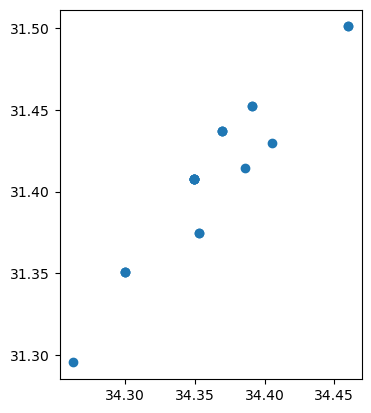

In [10]:
gdf_filtrado.plot()

In [11]:
# Create string column to 'submission_time'
gdf_filtrado['hora_subm'] = gdf_filtrado['_submission_time'].astype(str)

In [12]:
#Handle columns so they are not modified by arcgis when uploaded
def makeArcGISfriendly(df):
    df.columns = df.columns.str.replace(r"[ ]", "_", regex=True)
    df.columns = df.columns.str.replace(r"[.]", "_", regex=True)
    df.columns = df.columns.str.replace(r"[?]", "_", regex=True)
    df.columns = df.columns.str.replace(r"[']", "", regex=True)
    df.columns = df.columns.str.replace(r"[(]", "", regex=True)
    df.columns = df.columns.str.replace(r"[)]", "", regex=True)
    df.columns = df.columns.str.replace(r"[[]", "", regex=True)
    df.columns = df.columns.str.replace(r"[]]", "", regex=True)
    df.columns = df.columns.str.replace(r"[%]", "_", regex=True)
    df.columns = map(str.lower, df.columns)
    
    # Remove leading underscores
    df = df.rename(columns={
        '_id':'f_id',
        '_uuid':'f_uuid',
    })
    df.columns = df.columns.str.lstrip('_')
    
    #Truncate and ensure uniqueness
    seen = {}
    final_cols = []
    max_length = 31
    for col in df.columns:
        base = col[:max_length]
        new_col = base
        i = 1
        while new_col in seen:
            suffix = f"_{i}"
            trim_len = max_length - len(suffix)
            new_col = base[:trim_len] + suffix
            i += 1
        seen[new_col] = True
        final_cols.append(new_col)
    
    # Step 4: Apply to DataFrame
    df.columns = final_cols
    return df

gdf_exploded = makeArcGISfriendly(gdf_filtrado)

c:\Users\joses\anaconda3\Lib\site-packages\pandas\core\strings\object_array.py:172: FutureWarning: Possible nested set at position 1
  pat = re.compile(pat, flags=flags)


In [13]:
def simplifyGeometries(df):
    df['geometry'] = df['geometry'].centroid
    return df
    
gdf_exploded = simplifyGeometries(gdf_exploded)

seen = set()
unique_flags = []

for _, row in gdf_exploded.iterrows():
    if row['f_id'] in seen:
        unique_flags.append('')
    else:
        unique_flags.append('yes')
        seen.add(row['f_id'])

gdf_exploded['unique_'] = unique_flags

C:\Users\joses\AppData\Local\Temp\ipykernel_18188\3564463087.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['geometry'] = df['geometry'].centroid


In [ ]:
gdf_exploded.columns

In [ ]:
# Clean columns
gdf_colunas = gdf_exploded[['objectid', 'neighborhood', 'municipality', 'governorate', 'arabicname', 'governate_name',
       'municipality_name', 'neighborhood_name', 'location_gdf', 'gov_mun',
       'geometry', 'requesting_agency', 'please_specify', 'contact_person_name', 'contact_person_phone_number',
       'contact_person_email_address', 'location_of_planned_interventio',
       'intended_use_of_recycled_materi', 'please_specify_1',
       'requested_quantity', 'specify_the_measurement_unit', 'hora_subm',
       'f_id', 'f_uuid', 'submission_time', 'status', 'submitted_by', 'version__', 'tags', 'index',]]



# Repair columns names
gdf_colunas.columns = (
    gdf_colunas.columns
      .str.normalize('NFKD')
      .str.encode('ascii', errors='ignore').str.decode('utf-8')
      .str.replace('[^0-9a-zA-Z_]+', '_', regex=True)
      .str.replace('^[0-9]+', '', regex=True)
      .str.strip('_')
)

gdf_colunas = gdf_colunas.rename(columns={'': 'empty_field'})

gdf_colunas = gdf_colunas.rename(columns={
    'location_of_planned_interventio': 'planned_intervention',
    'intended_use_of_recycled_materi': 'use_of_recycled_material'
})

# Limitar cada nome a 31 caracteres
gdf_colunas.columns = [c[:20] for c in gdf_colunas.columns]

In [34]:
gdf_colunas.columns

Index(['neighborhood', 'municipality', 'governorate', 'arabicname',
       'governate_name', 'municipality_name', 'neighborhood_name',
       'location_gdf', 'gov_mun', 'geometry', 'requesting_agency',
       'please_specify', 'contact_person_name', 'contact_person_phone',
       'contact_person_email', 'planned_intervention', 'use_of_recycled_mate',
       'please_specify_1', 'requested_quantity', 'specify_the_measurem',
       'hora_subm', 'f_id', 'f_uuid', 'status', 'submitted_by', 'version',
       'tags', 'index'],
      dtype='object')

In [ ]:
#Run locally and upload manually to ArcGIS the first time!
gdf_colunas.to_file("DWG_Gaza_Aggregate_for_Recycling.gpkg")

In [35]:
#### UPDATE DATA IN ARCGIS

#Connect to the ArcGIS Enterprise portal

AGOL_USERNAME = 'h.partow'
AGOL_PASSWORD = 'R&Runit2024'
gis = GIS('https://wesrmapportal.unep.org/portal/', AGOL_USERNAME, AGOL_PASSWORD)

# Access the feature-layer through its URL
file = "https://wesrmapportal.unep.org/arcgis/rest/services/Hosted/DWG_Gaza_Aggregate_for_Recycling/FeatureServer"

# Access the feature-layer through its URL
agg_file = 'DWG_Gaza_Aggregate_for_Recycling'

In [36]:
def searchArcgis(keyword):
    if not isinstance(keyword, str):
        raise TypeError(f"Esperado 'str' em 'keyword', recebido {type(keyword)} → {keyword}")
    results = gis.content.search(f'title:\"{keyword}\"', item_type="Feature Layer")
    if not results:
        print("Nenhum resultado encontrado para", keyword)
        return None
    results_sorted = sorted(results, key=lambda x: x.modified, reverse=True)
    return results_sorted[0]

search_agg = searchArcgis(agg_file)

<Item title:"DWG_Gaza_Aggregate_for_Recycling" type:Feature Layer Collection owner:h.partow>
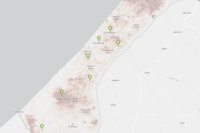

In [18]:
search_agg

In [37]:
def updateFeature(search_results, gdf):

    item = gis.content.get(search_results.id)

    flc = FeatureLayerCollection.fromitem(item)
    layer = flc.layers[0]  # Assuming you're working with the first layer


    # Step 1: Truncate features
    truncate_result = layer.manager.truncate()
    print("Truncate result:", truncate_result)

    # Keep only matching columns
    expected_fields = [f["name"] for f in layer.properties.fields if f["name"] != "fid"]
    gdf = gdf[[col for col in gdf.columns if col in expected_fields or col == "geometry"]]

    gdf = gdf.to_crs(epsg=4326)

    sedf = GeoAccessor.from_geodataframe(gdf)

    fs = FeatureSet.from_dataframe(sedf)

    result = layer.edit_features(adds=fs.features)
    print("Result:", result)
    return(result)

In [20]:
gdf_colunas.to_file('agg_teste.gpkg')

In [38]:
print(gdf_colunas.dtypes)


neighborhood              object
municipality              object
governorate               object
arabicname                object
governate_name            object
municipality_name         object
neighborhood_name         object
location_gdf              object
gov_mun                   object
geometry                geometry
requesting_agency         object
please_specify            object
contact_person_name       object
contact_person_phone       int64
contact_person_email      object
planned_intervention      object
use_of_recycled_mate      object
please_specify_1          object
requested_quantity         int64
specify_the_measurem      object
hora_subm                 object
f_id                       int64
f_uuid                    object
status                    object
submitted_by             float64
version                   object
tags                     float64
index                      int64
dtype: object


In [47]:
# Campos que devem ser double
double_fields = ["please_specify_1", "empty_field"]

for col in double_fields:
    if col in gdf_colunas.columns:
        gdf_colunas[col] = pd.to_numeric(gdf_colunas[col], errors="coerce")

# Campo que precisa ser string
if "contact_person_phone_number" in gdf_colunas.columns:
    gdf_colunas["contact_person_phone_number"] = (
        gdf_colunas["contact_person_phone_number"].astype(str)
    )

# Campos big integer → garantir int
bigint_fields = ["requested_quantity", "index", "f_id"]
for col in bigint_fields:
    if col in gdf_colunas.columns:
        gdf_colunas[col] = gdf_colunas[col].astype("Int64")

In [48]:
updateFeature(search_agg, gdf_colunas)

Truncate result: {'success': True}
Result: {'addResults': [{'success': True, 'objectId': 1}, {'success': True, 'objectId': 2}, {'success': True, 'objectId': 3}, {'success': True, 'objectId': 4}, {'success': True, 'objectId': 5}, {'success': True, 'objectId': 6}, {'success': True, 'objectId': 7}, {'success': True, 'objectId': 8}, {'success': True, 'objectId': 9}, {'success': True, 'objectId': 10}, {'success': True, 'objectId': 11}, {'success': True, 'objectId': 12}, {'success': True, 'objectId': 13}, {'success': True, 'objectId': 14}, {'success': True, 'objectId': 15}, {'success': True, 'objectId': 16}, {'success': True, 'objectId': 17}, {'success': True, 'objectId': 18}, {'success': True, 'objectId': 19}, {'success': True, 'objectId': 20}, {'success': True, 'objectId': 21}], 'updateResults': [], 'deleteResults': []}


{'addResults': [{'success': True, 'objectId': 1},
  {'success': True, 'objectId': 2},
  {'success': True, 'objectId': 3},
  {'success': True, 'objectId': 4},
  {'success': True, 'objectId': 5},
  {'success': True, 'objectId': 6},
  {'success': True, 'objectId': 7},
  {'success': True, 'objectId': 8},
  {'success': True, 'objectId': 9},
  {'success': True, 'objectId': 10},
  {'success': True, 'objectId': 11},
  {'success': True, 'objectId': 12},
  {'success': True, 'objectId': 13},
  {'success': True, 'objectId': 14},
  {'success': True, 'objectId': 15},
  {'success': True, 'objectId': 16},
  {'success': True, 'objectId': 17},
  {'success': True, 'objectId': 18},
  {'success': True, 'objectId': 19},
  {'success': True, 'objectId': 20},
  {'success': True, 'objectId': 21}],
 'updateResults': [],
 'deleteResults': []}